In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, SimpleRNN

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

In [3]:
data = pd.read_csv('AAPL.csv', na_values=["null"], index_col="Date", parse_dates = True, infer_datetime_format=True)
data = data.loc['2005-01-01' : '2020-01-01']
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700
2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300
2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500
2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600
2019-12-31,289.929993,293.679993,289.519989,293.649994,292.954712,25201400


<AxesSubplot:xlabel='Date'>

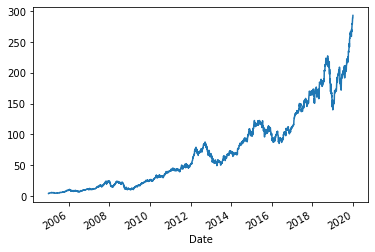

In [4]:
data["Adj Close"].plot()

In [5]:
data['Gap'] = data['Adj Close'] - data.Open
data['Gap'] = data['Gap'].shift(-1)

data['nextDay'] = data['Adj Close'].shift(-1)

data.dropna(inplace = True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis = 1, inplace = True)

data

,Open,High,Low,Adj Close,Gap,nextDay
0,4.627143,4.650714,4.471428,3.924165,-0.591961,3.964467
1,4.556428,4.676429,4.497857,3.964467,-0.605098,3.999188
2,4.604286,4.660714,4.575000,3.999188,-0.616997,4.002288
3,4.619286,4.636428,4.523571,4.002288,-0.349156,4.293701
4,4.642857,4.973571,4.625000,4.293701,-0.712136,4.275722
...,...,...,...,...,...,...
3769,280.529999,284.250000,280.369995,283.327576,-1.093079,283.596924
3770,284.690002,284.890015,282.920013,283.596924,4.403595,289.223602
3771,284.820007,289.980011,284.700012,289.223602,-2.006165,289.113831
3772,291.119995,293.970001,288.119995,289.113831,1.369781,290.829773


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
print(data_scaled)

[[2.46767147e-04 4.93756778e-05 0.00000000e+00 0.00000000e+00
  6.63243539e-01 0.00000000e+00]
 [0.00000000e+00 1.38250250e-04 9.31740985e-05 1.40471420e-04
  6.62647610e-01 1.20146395e-04]
 [1.67004079e-04 8.39370041e-05 3.65139920e-04 2.61490791e-04
  6.62107773e-01 1.30873943e-04]
 ...
 [9.78015392e-01 9.86209723e-01 9.87942887e-01 9.94401745e-01
  5.99087372e-01 9.86709304e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 9.94019140e-01
  7.52239172e-01 9.92647022e-01]
 [9.94207206e-01 9.95576045e-01 9.89776102e-01 1.00000000e+00
  8.27316407e-01 1.00000000e+00]]


In [7]:
# multiple feature from data provided to the model

X = []
backcandles = 100

#data_set_scaled[0].size):#2 columns are target not X
for j in range(6):
    X.append([])
    for i in range(backcandles, data_scaled.shape[0]):#backcandles+2
        X[j].append(data_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# -1, target with next day price , -2 target with the gap between price
X, yi = np.array(X), np.array(data_scaled[backcandles:,-2])
y = np.reshape(yi,(len(yi),1))

print(data_scaled.shape[0])


3774


In [8]:
# split data into train and test

portion = int(len(X) * 0.8)

X_train, X_test = X[:portion], X[portion:]
y_train, y_test = y[:portion], y[portion:]


### RNN Model

In [9]:

RNN_input = Input(shape = (backcandles, 6), name = 'RNN_input')

input_data_RNN = SimpleRNN(100, name = 'first_layer')(RNN_input)
input_data_RNN = Dense(1, name = 'dense_layer')(input_data_RNN)

input_data_RNN = SimpleRNN(100, name = 'second_layer')(RNN_input)
input_data_RNN = Dense(1, name = 'dense_layer')(input_data_RNN)

output_RNN = Activation('linear', name = 'output')(input_data_RNN)

Model_RNN = Model(inputs = RNN_input, outputs = output_RNN)

# compiling RNN
Model_RNN.compile(optimizer = "adam", loss = "mse")

# fitting the RNN
history_RNN = Model_RNN.fit(X_train, y_train, epochs = 10, batch_size = 15)

Epoch 1/10
196/196 [==============================] - 4s 16ms/step - loss: 0.0050
Epoch 2/10
196/196 [==============================] - 3s 16ms/step - loss: 0.0023
Epoch 3/10
196/196 [==============================] - 3s 16ms/step - loss: 0.0021
Epoch 4/10
196/196 [==============================] - 3s 16ms/step - loss: 0.0022
Epoch 5/10
196/196 [==============================] - 3s 16ms/step - loss: 0.0021
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0021
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0019
Epoch 8/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0021
Epoch 9/10
196/196 [==============================] - 3s 13ms/step - loss: 0.0018
Epoch 10/10
196/196 [==============================] - 3s 14ms/step - loss: 0.0019


In [10]:
Model_RNN.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_input (InputLayer)       [(None, 100, 6)]          0         
_________________________________________________________________
second_layer (SimpleRNN)     (None, 100)               10700     
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 101       
_________________________________________________________________
output (Activation)          (None, 1)                 0         
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Make prediction 
prediction_RNN = Model_RNN.predict(X_test)

for i in range(10):
    print(prediction_RNN[i], y_test[i])

[0.4495886] [0.44044104]
[0.44388735] [0.49361942]
[0.4462106] [0.44101109]
[0.4389361] [0.44981929]
[0.43913385] [0.46493158]
[0.43369597] [0.45457522]
[0.42979187] [0.43987792]
[0.4246513] [0.46751877]
[0.43937838] [0.41774509]
[0.43977296] [0.44042132]


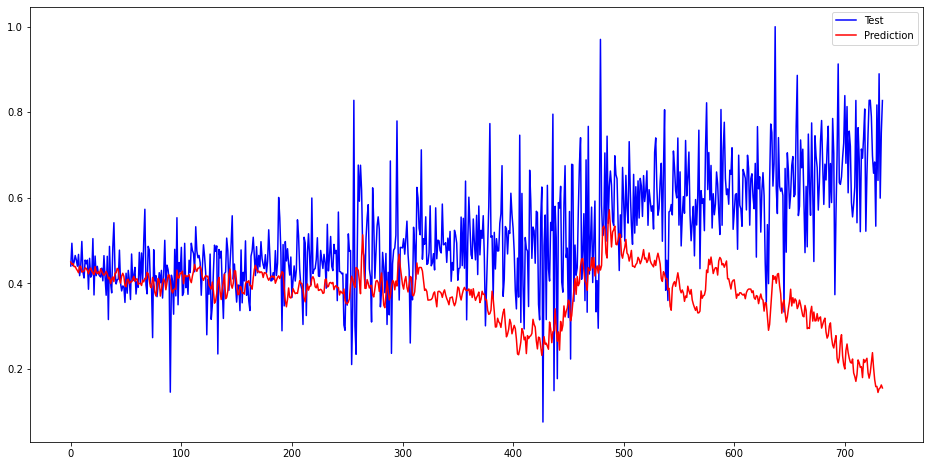

In [12]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(prediction_RNN, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

loss at epoch 1: 0.005034034140408039
loss at epoch 10: 0.0018933069659397006


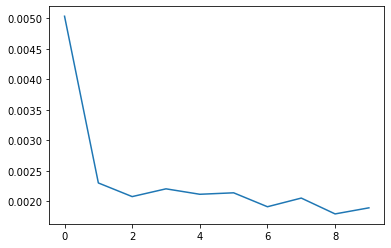

In [13]:
print(f"loss at epoch 1: {history_RNN.history['loss'][0]}")
print(f"loss at epoch 10: {history_RNN.history['loss'][9]}")
plt.plot(history_RNN.history['loss'])

### LSTM Model

In [14]:
# fit and compile LSTM model 
np.random.seed(10)

LSTM_input = Input(shape = (backcandles, 6), name = 'LSTM_input')

input_data = LSTM(100, name = 'first_layer')(LSTM_input)
input_data = Dense(1, name = 'dense_layer')(input_data)

input_data = LSTM(100, name = 'second_layer')(LSTM_input)
input_data = Dense(1, name = 'dense_layer')(input_data)

output = Activation('linear', name = 'output')(input_data)

model = Model(inputs = LSTM_input, outputs = output)

model.compile(optimizer = 'adam', loss = 'mse')
history = model.fit(x = X_train, y = y_train, batch_size = 15, epochs = 10, shuffle = True, validation_split = 0.1)

Epoch 1/10
177/177 [==============================] - 11s 45ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 2/10
177/177 [==============================] - 8s 44ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 3/10
177/177 [==============================] - 8s 43ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 4/10
177/177 [==============================] - 8s 44ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 5/10
177/177 [==============================] - 8s 42ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 6/10
177/177 [==============================] - 8s 43ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 7/10
177/177 [==============================] - 8s 43ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 8/10
177/177 [==============================] - 8s 43ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 9/10
177/177 [==============================] - 7s 42ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 10/10
177/177 [==============================] - 6s 35ms/step - loss: 0.0016 - val_l

In [15]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_input (InputLayer)      [(None, 100, 6)]          0         
_________________________________________________________________
second_layer (LSTM)          (None, 100)               42800     
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 101       
_________________________________________________________________
output (Activation)          (None, 1)                 0         
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Make prediction 
prediction = model.predict(X_test)

for i in range(10):
    print(prediction[i], y_test[i])

[0.41983154] [0.44044104]
[0.41970736] [0.49361942]
[0.41957203] [0.44101109]
[0.41587242] [0.44981929]
[0.41317007] [0.46493158]
[0.41179842] [0.45457522]
[0.41048047] [0.43987792]
[0.40853396] [0.46751877]
[0.40807733] [0.41774509]
[0.40658095] [0.44042132]


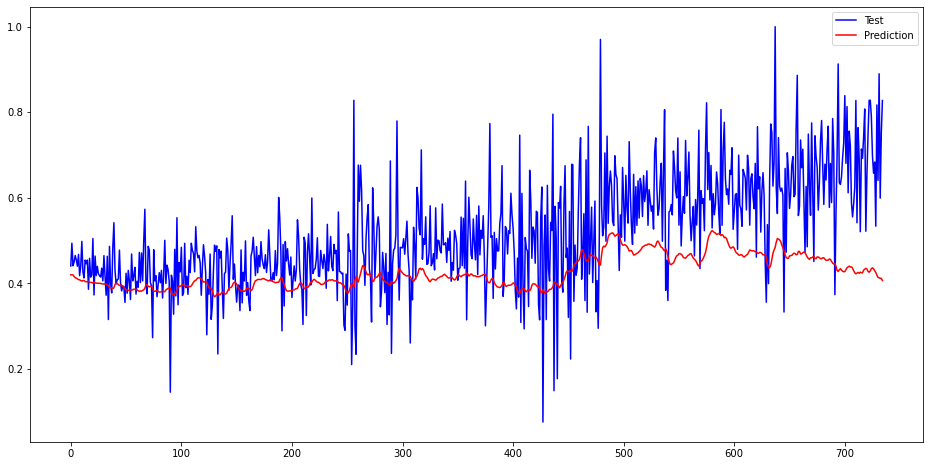

In [17]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(prediction, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

loss at epoch 1: 0.006828946992754936
loss at epoch 10: 0.0016283410368487239


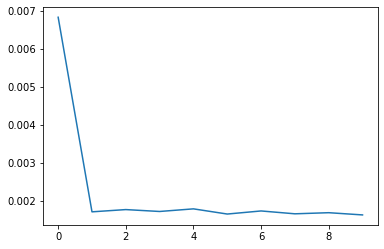

In [18]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 10: {history.history['loss'][9]}")
plt.plot(history.history['loss'])

### Reference:

OLEH ONYSHCHAK 2019, ‘Stock Market Dataset’, Kaggle, <https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset>.

CodeTrading 2022, ‘LSTM Trap Top Mistake In Price Movement Predictions And Trading Algorithms’, YouTube, <https://www.youtube.com/watch?v=lhrCz6t7rmQ>.

CodeTrading 2022, ‘Recurrent Neural Networks | LSTM Price Movement Predictions For Trading Algorithms’, YouTube, < https://www.youtube.com/watch?v=hpfQE0bTeA4>.

OZKAN OZTURK 2020, ‘Stock Price prediction by simple RNN and LSTM’, Kaggle, <https://www.kaggle.com/code/ozkanozturk/stock-price-prediction-by-simple-rnn-and-lstm>.

BUĞRA ALDAL 2022, ‘Stock Price Prediction’, Kaggle, <https://www.kaggle.com/code/buraaldal/stock-price-prediction>.